In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mintpy
from mintpy.utils import readfile, utils as ut 
from mintpy.objects import timeseries
import cartopy.crs as ccrs
from mintpy import view
import datetime
from operator import itemgetter 
import h5py
from miaplpy.objects.invert_pixel import process_pixel 
import matplotlib.dates as mdates
from miaplpy.find_short_baselines import get_baselines_dict
import matplotlib.colors as mcolors

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]



def get_dates_ts(proj_dir, points_lalo, refy, refx, reftype, win_s=5):
    from mintpy.objects import timeseries   
  
    tsStack = proj_dir + '/{}'.format('timeseries_SET_ERA5_demErr.h5')
    gStack = './LassenSenDT042/inputs/geometryRadar.h5'
    atr = readfile.read_attribute(tsStack)
    coord = ut.coordinate(atr, gStack)
    stack_obj = timeseries(tsStack)
    stack_obj.open(print_msg=False)
    date_list = stack_obj.get_date_list()
    num_dates = len(date_list)
    
    ts = np.zeros([len(points_lalo), num_dates])
    
    for t, coord in enumerate(points_lalo):
    
        if reftype == 'lalo':
            dates, ts[t, :] = ut.read_timeseries_lalo(coord[0], coord[1], tsStack, lookup_file=gStack, 
                                                      ref_lat=refy, ref_lon=refx, win_size=win_s, unit='cm', 
                                                      print_msg=True)[0:2]
        if reftype =='yx':
            dates, ts[t, :] = ut.read_timeseries_yx(coord[0], coord[1], tsStack, ref_y=refy, ref_x=refx, 
                                                    win_size=win_s, unit='cm', print_msg=True)[0:2]
    
        
    x_values = [date.timetuple().tm_yday for date in dates]
    x = np.zeros([len(x_values),1])
    m = 0
    for t, value in enumerate(x_values):
        x[t] = value
        if t > 0: 
            if value < x[t-1]:
                if value < x_values[t-1]:
                    m += 360
                    x[t] += m
                else:
                    x[t] += m
                
    x = [y - x[0] for y in x]
    return dates, x, ts



center = 0
divnorm = mcolors.TwoSlopeNorm(vmin=0,vcenter=0.3, vmax=1)
hex_list = ['#7B0099','#DF2A8E','#ff7b25', '#ffcc5c', '#ffeead']
cmapc=get_continuous_cmap(hex_list)
normc=divnorm

In [3]:


lat_P665 = 40.4555 
lon_P665= -121.5263 

lat_P667 = 40.4666 
lon_P667 = -121.4679 


points_lalo = [(lat_P665, lon_P665),
               (lat_P667, lon_P667)]

reflat = 40.540 
reflon = -121.577 


prj_dir = './LassenSenDT042'
# Data is not available on Zenodo because of the size.
# but you can process all using the template files in ./templates if you have the coregistered SLCs generated with ISCE

project_dirs = [prj_dir + '/single_reference',
                prj_dir + '/delaunay_6',
                prj_dir + '/mini_stacks',
                prj_dir + '/sequential_3']

data = [x + '/geocoded/geo_velocity.h5' for x in project_dirs]


geom_file = prj_dir + '/inputs/geometryRadar.h5'

box = ['40.3632:40.6334','-121.6971:-121.3132']

lat = [float(i) for i in box[0].split(':')]
lon = [float(i) for i in box[1].split(':')]


baselines, dates = get_baselines_dict(prj_dir + '/inputs/baselines')
out_dir = './out_figures'

In [4]:
def read_ds(proj_dir):
    velocity_file = proj_dir + '/geocoded/geo_velocity.h5'
    geometry_file = proj_dir + '/geocoded/geo_geometryRadar.h5'
    mask_file_t = proj_dir + '/geocoded/geo_maskTempCoh.h5'
    latitude = readfile.read(geometry_file, datasetName='latitude')[0]
    longitude = readfile.read(geometry_file, datasetName='longitude')[0]
    
    
    mask = np.ones(latitude.shape, dtype=np.int8)
    

    velocity = readfile.read(velocity_file, datasetName='velocity')[0]
    mask = readfile.read(mask_file_t, datasetName='mask')[0]
    
    vel = np.array(velocity[mask==1]*100)
    lat = np.array(latitude[mask==1])
    lon = np.array(longitude[mask==1])
    
    return lat, lon, vel
    

In [5]:
# Referencing
#for prj in project_dirs:
#    velfile = prj + '/velocity.h5'
    #!reference_point.py $velfile -l $reflat -L $reflon --lookup $geom_file
    #!reference_point.py $velfile -x $refx -y $refy --lookup $geom_file

In [6]:
# Geocoding
#for prj in project_dirs:
#    velfile = prj + '/velocity.h5'
#    tsfile = prj + '/timeseries_ERA5_demErr.h5'
#    temp_coh = prj + '/temporalCoherence.h5'
#    !mask.py $prj_dir/inverted/tempCoh_full -m $prj_dir/shadow_mask.h5 -o $temp_coh
#    geocode_dir = prj + '/geocoded'
#    os.makedirs(geocode_dir, exist_ok=True)
#    !geocode.py $geom_file -l $geom_file --outdir $geocode_dir --lalo 0.000185185 0.000185185
    #!geocode.py $velfile -l $geom_file --outdir $geocode_dir --lalo 0.000185185 0.000185185
    #!geocode.py $temp_coh -l $geom_file --outdir $geocode_dir --lalo 0.000185185 0.000185185
    #!generate_mask.py $geocode_dir/geo_temporalCoherence.h5 -m .5 -o $geocode_dir/geo_maskTempCoh.h5

In [9]:
# Difference velocity
velfile_sr = project_dirs[0] + '/geocoded/geo_velocity.h5'
geocode_dir = project_dirs[0] + '/geocoded/'
out_files = ['diff_vel_de_sr.h5', 'diff_vel_mi_sr.h5', 'diff_vel_se_sr.h5']
i = 0
#for prj in project_dirs[1::]:
#    velfile = prj + '/geocoded/geo_velocity.h5'
#    out_file = geocode_dir + out_files[i]
#    !diff.py $velfile $velfile_sr -o $out_file
#    i += 1
    

In [10]:
velfile_sr = project_dirs[1] + '/geocoded/geo_velocity.h5'
geocode_dir = project_dirs[0] + '/geocoded/'
out_files = ['diff_vel_sr_de.h5','diff_vel_de_de.h5', 'diff_vel_mi_de.h5', 'diff_vel_se_de.h5']
i = 0
#for prj in project_dirs:
#    velfile = prj + '/geocoded/geo_velocity.h5'
#    out_file = geocode_dir + out_files[i]
#    !diff.py $velfile $velfile_sr -o $out_file
#    i += 1

In [5]:
latt, lonn, vel_sr = read_ds(project_dirs[0])  # cm/y
latt, lonn, vel_de = read_ds(project_dirs[1])  # cm/y
latt, lonn, vel_mi = read_ds(project_dirs[2])  # cm/y
latt, lonn, vel_se = read_ds(project_dirs[3])  # cm/y


In [8]:
diff_de_sr = vel_sr - vel_de
diff_de_mi = vel_mi - vel_de
diff_de_se = vel_se - vel_de  # 3 connection

print('delaunay rmse:', np.sqrt(np.sum(diff_de_sr.flatten()**2)/(len(diff_de_sr.flatten())-1)))
print('ministacks rmse:', np.sqrt(np.sum(diff_de_mi.flatten()**2)/(len(diff_de_mi.flatten())-1)))
print('sequential rmse:', np.sqrt(np.sum(diff_de_se.flatten()**2)/(len(diff_de_se.flatten())-1)))


print('mean, std: ', np.mean(diff_de_sr), np.std(diff_de_sr))
print('mean, std: ', np.mean(diff_de_mi), np.std(diff_de_mi))
print('mean, std: ', np.mean(diff_de_se), np.std(diff_de_se))


delaunay rmse: 0.19310378643569487
ministacks rmse: 0.5296293964451654
sequential rmse: 1.2872915164625613
mean, std:  -0.08311083 0.17430337
mean, std:  -0.39966595 0.34752598
mean, std:  0.8075457 1.0024917


In [7]:
diff_sr_de = vel_de - vel_sr
diff_sr_mi = vel_mi - vel_sr
diff_sr_se = vel_se - vel_sr

print('delaunay rmse:', np.sqrt(np.sum(diff_sr_de.flatten()**2)/(len(diff_sr_de.flatten())-1)))
print('ministacks rmse:', np.sqrt(np.sum(diff_sr_mi.flatten()**2)/(len(diff_sr_mi.flatten())-1)))
print('sequential rmse:', np.sqrt(np.sum(diff_sr_se.flatten()**2)/(len(diff_sr_se.flatten())-1)))


print('mean, std: ', np.mean(diff_sr_de), np.std(diff_sr_de))
print('mean, std: ', np.mean(diff_sr_mi), np.std(diff_sr_mi))
print('mean, std: ', np.mean(diff_sr_se), np.std(diff_sr_se))


delaunay rmse: 0.19310378643569487
ministacks rmse: 0.4556634774317766
sequential rmse: 1.367385505813996
mean, std:  0.08311083 0.17430337
mean, std:  -0.31655523 0.32775304
mean, std:  0.8906562 1.037532


In [8]:
geometry_file = project_dirs[0] + '/geocoded/geo_geometryRadar.h5'
latitude = readfile.read(geometry_file, datasetName='latitude')[0]
longitude = readfile.read(geometry_file, datasetName='longitude')[0]
height = readfile.read(geometry_file, datasetName='height')[0]


In [9]:
from scipy.ndimage.filters import gaussian_filter
X = gaussian_filter(longitude, 0.9)
Y = gaussian_filter(latitude, 0.9)
Z = gaussian_filter(height, 0.9)


view.py /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/single_reference/geocoded/geo_velocity.h5 velocity --notitle --fontsize 18 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat 40.3632 40.6334 --sub-lon -121.6971 -121.3132 --noverbose --notitle --ref-lalo 40.54 -121.577 -v -1 1
view.py /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/delaunay_6/geocoded/geo_velocity.h5 velocity --notitle --fontsize 18 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat 40.3632 40.6334 --sub-lon -121.6971 -121.3132 --noverbose --notitle --ref-lalo 40.54 -121.577 -v -1 1
view.py /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/mini_stacks/geocoded/geo_velocity.h5 velocity --notitle --fontsize 18 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --su

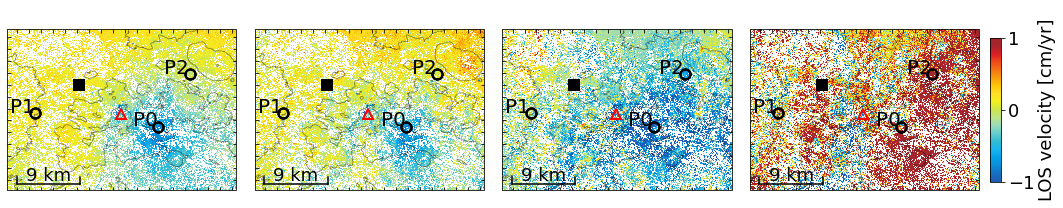

In [43]:
## Plot velocities

data = [x + '/geocoded/geo_velocity.h5' for x in project_dirs]
#data = [x + '/geocoded_sub/geo_vel_2020.h5' for x in project_dirs]

dem_file = os.path.expanduser(prj_dir + '/dem.dem.wgs84')

points_lalo = np.array([(40.491, -121.507)])  #volcanoes



points_lalo1 = np.array([(40.4728 , -121.4966), 
                        (40.4555, -121.5263),
                        (40.4666, -121.4679)]) 

points_lalo1 = np.array([(40.4697 , -121.4438), 
                        (40.4917, -121.6499),
                        (40.5571, -121.3917)]) 

labels1 = ['P0', 'P1', 'P2']

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()
plt.rcParams["font.size"] = "18"

titles = ['Single reference','Delaunay','Annual ministacks',  'Sequential(3 conn)']

reflat = 40.540 
reflon = -121.577 

fsize = 12

box = ['40.3632:40.6334','-121.6971:-121.3132']

lat = [float(i) for i in box[0].split(':')]
lon = [float(i) for i in box[1].split(':')]


factor = [3,2,2,2]
#titles = ['Ascending', 'Descending', 'Vertical', 'East-West']

# options for view.py

#opt =  ' --dem {}  --contour-step 200 --contour-smooth 0.0 --shade-az 45 '.format(dem_file)
#opt += ' --shade-exag 0.001 --shade-min -8000 --shade-max 4000 '
opt = ' --notitle --fontsize 18 --nocbar --alpha 1 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature'
#opt += ' --dem {} --contour-step 400 --contour-smooth 0.0 --shade-az -45 '.format(dem_file)
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 '
opt += ' --sub-lat {} {} --sub-lon {} {} '.format(lat[0], lat[1], lon[0], lon[1])
opt += ' --noverbose  --notitle --ref-lalo {} {}'.format(reflat, reflon)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,10), subplot_kw=dict(projection=ccrs.PlateCarree()))


for t in range(4):
    ax = axs[t]
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]], crs=ccrs.PlateCarree())

    cmd = 'view.py {} velocity'.format(data[t]) + opt 
    cmd += ' -v -{f} {f} '.format(f=1)
    ax.set_title('Velocity', fontsize=fsize)
    d_v, atr, inps = view.prep_slice(cmd)
    im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
    
    ax.contour(X, Y, Z, 4, colors='k', alpha=0.5,linewidths=0.7, transform=ccrs.PlateCarree())

    
    '''
    if t == 0:
        ax.scatter(lonn, latt, c=vel_sr, cmap='jet',  vmin=-1, vmax=1,
                   s=0.001, alpha=1, transform=ccrs.PlateCarree())
        
    elif t == 1:
        ax.scatter(lonn, latt, c=vel_de, cmap='jet',  vmin=-1, vmax=1,
                   s=0.001, alpha=1, transform=ccrs.PlateCarree())
        
    elif t == 2:
        ax.scatter(lonn, latt, c=vel_mi, cmap='jet',  vmin=-1, vmax=1,
                   s=0.001, alpha=1, transform=ccrs.PlateCarree())
        
    else:
        im = ax.scatter(lonn, latt, c=vel_se, cmap='jet',  vmin=-1, vmax=1,
                   s=0.001, alpha=1, transform=ccrs.PlateCarree())
       
    '''
    for x in range(points_lalo.shape[0]):
       
        #ax.text(points_lalo[x,1]-0.001, points_lalo[x,0]+0.002, labels[x], fontsize=20, 
        #        horizontalalignment='right', transform=ccrs.PlateCarree())
              
        ax.plot(points_lalo[:,1], points_lalo[:,0], '^', markersize=10, markerfacecolor=(0,0,0,0), 
                    markeredgecolor='r', markeredgewidth=2, transform=ccrs.PlateCarree())
        
        ax.plot(reflon, reflat, 's', markersize=10, markerfacecolor='k', 
                    markeredgecolor='k', markeredgewidth=2, transform=ccrs.PlateCarree())
        
    
    for x in range(points_lalo1.shape[0]):
       
        ax.text(points_lalo1[x,1]-0.001, points_lalo1[x,0]+0.002, labels1[x], fontsize=20, 
                horizontalalignment='right', transform=ccrs.PlateCarree())
              
        ax.plot(points_lalo1[:,1], points_lalo1[:,0], 'o', markersize=10, markerfacecolor=(0,0,0,0), 
                    markeredgecolor='k', markeredgewidth=2, transform=ccrs.PlateCarree())
    
    ax.set_title(' ') #titles[t])
        

cbar_ax = fig.add_axes([0.96, 0.4, 0.01, 0.2])
fig.colorbar(im, cax=cbar_ax, ticks=[-1,0,1], label='LOS velocity [cm/yr]')
#fig.colorbar(im, cax=cbar_ax, label='Velocity (cm/yr)')

#cbar=fig.colorbar(im, ax=axs[4], ticks=[-3,0,3], label='cm/yr')
fig.subplots_adjust(wspace=0.08, hspace=-0.3, left=0.05, right=0.95, top=0.95, bottom=0.05)      


out_file = os.path.abspath(out_dir + '/velocity_lassen_mib.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=300)
print('save figure to file', out_file)
plt.show()

view.py /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/single_reference/geocoded/diff_vel_de_sr.h5 velocity -m /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/single_reference/geocoded/geo_maskTempCoh.h5 --notitle --fontsize 18 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat 40.3632 40.6334 --sub-lon -121.6971 -121.3132 --noverbose --notitle --ref-lalo 40.54 -121.577 -v -1 1
view.py /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/single_reference/geocoded/diff_vel_mi_sr.h5 velocity -m /Volumes/SaraMNew/scratch/minopy_subsets/LassenSenDT042/single_reference/geocoded/geo_maskTempCoh.h5 --notitle --fontsize 18 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat 40.3632 40.6334 --sub-lon -121.6971 -121.3132 --noverbose --notitle --ref-lalo 40.54 -121.577 -v -1 1
view.py /Volumes/SaraMNew/scratch/minopy_s

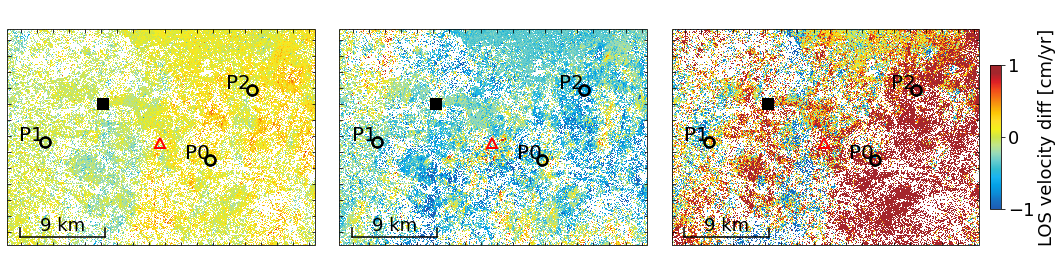

In [24]:
## Plot velocity differences


#data = [x + '/geocoded/geo_velocity.h5' for x in project_dirs]

geocode_dir = project_dirs[0] + '/geocoded/'
out_files = ['diff_vel_de_sr.h5', 'diff_vel_mi_sr.h5', 'diff_vel_se_sr.h5']
data = [geocode_dir + x for x in out_files]
#data = [x + '/geocoded_sub/geo_vel_2020.h5' for x in project_dirs]

mask_f = geocode_dir + 'geo_maskTempCoh.h5'
dem_file = os.path.expanduser('./Lassen_data/dem.dem.wgs84')

points_lalo = np.array([(40.491, -121.507)])  #volcanoes



points_lalo1 = np.array([(40.4728 , -121.4966), 
                        (40.4555, -121.5263),
                        (40.4666, -121.4679)]) 

points_lalo1 = np.array([(40.4697 , -121.4438), 
                        (40.4917, -121.6499),
                        (40.5571, -121.3917)]) 

labels1 = ['P0', 'P1', 'P2']

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()
plt.rcParams["font.size"] = "18"

titles = ['Delaunay','Annual ministacks', 'Sequential(3 conn)']

reflat = 40.540 
reflon = -121.577 

fsize = 12

box = ['40.3632:40.6334','-121.6971:-121.3132']

lat = [float(i) for i in box[0].split(':')]
lon = [float(i) for i in box[1].split(':')]


factor = [3,2,2,2]
#titles = ['Ascending', 'Descending', 'Vertical', 'East-West']

# options for view.py

#opt =  ' --dem {}  --contour-step 200 --contour-smooth 0.0 --shade-az 45 '.format(dem_file)
#opt += ' --shade-exag 0.001 --shade-min -8000 --shade-max 4000 '
opt = ' --notitle --fontsize 18 --nocbar --alpha 1 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature'
#opt += ' --dem {} --contour-step 400 --contour-smooth 0.0 --shade-az -45 '.format(dem_file)
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 '
opt += ' --sub-lat {} {} --sub-lon {} {} '.format(lat[0], lat[1], lon[0], lon[1])
opt += ' --noverbose  --notitle --ref-lalo {} {}'.format(reflat, reflon)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,10), subplot_kw=dict(projection=ccrs.PlateCarree()))


for t in range(3):
    ax = axs[t]
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]], crs=ccrs.PlateCarree())

    cmd = 'view.py {} velocity -m {}'.format(data[t], mask_f) + opt 
    cmd += ' -v -{f} {f} '.format(f=1)
    ax.set_title('Velocity', fontsize=fsize)
    d_v, atr, inps = view.prep_slice(cmd)
    im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
    

    for x in range(points_lalo.shape[0]):
       
        #ax.text(points_lalo[x,1]-0.001, points_lalo[x,0]+0.002, labels[x], fontsize=20, 
        #        horizontalalignment='right', transform=ccrs.PlateCarree())
              
        ax.plot(points_lalo[:,1], points_lalo[:,0], '^', markersize=10, markerfacecolor=(0,0,0,0), 
                    markeredgecolor='r', markeredgewidth=2, transform=ccrs.PlateCarree())
        
        ax.plot(reflon, reflat, 's', markersize=10, markerfacecolor='k', 
                    markeredgecolor='k', markeredgewidth=2, transform=ccrs.PlateCarree())
        
    
    for x in range(points_lalo1.shape[0]):
       
        ax.text(points_lalo1[x,1]-0.001, points_lalo1[x,0]+0.002, labels1[x], fontsize=20, 
                horizontalalignment='right', transform=ccrs.PlateCarree())
              
        ax.plot(points_lalo1[:,1], points_lalo1[:,0], 'o', markersize=10, markerfacecolor=(0,0,0,0), 
                    markeredgecolor='k', markeredgewidth=2, transform=ccrs.PlateCarree())
    
    ax.set_title(' ') #titles[t])
        

cbar_ax = fig.add_axes([0.96, 0.4, 0.01, 0.2])
fig.colorbar(im, cax=cbar_ax, ticks=[-1,0,1], label='LOS velocity diff [cm/yr]')
#fig.colorbar(im, cax=cbar_ax, label='Velocity (cm/yr)')

#cbar=fig.colorbar(im, ax=axs[4], ticks=[-3,0,3], label='cm/yr')
fig.subplots_adjust(wspace=0.08, hspace=-0.3, left=0.05, right=0.95, top=0.95, bottom=0.05)      


out_file = os.path.abspath(out_dir + '/velocity_lassen_mib_diff.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=300)
print('save figure to file', out_file)
plt.show()

In [81]:
reflat = 40.540 
reflon = -121.577 

dates_sr, x_sr, ts_sr = get_dates_ts(project_dirs[0], points_lalo1, reflat, reflon, 'lalo')  # single reference
dates_de, x_de, ts_de = get_dates_ts(project_dirs[1], points_lalo1, reflat, reflon, 'lalo')  # delaunay
dates_ms, x_ms, ts_ms = get_dates_ts(project_dirs[2], points_lalo1, reflat, reflon, 'lalo')  # mini stacks
dates_se3, x_se3, ts_se3 = get_dates_ts(project_dirs[3], points_lalo1, reflat, reflon, 'lalo')  # sequential

for i, date in enumerate(dates):
    if datetime.datetime.strptime(date, '%Y%m%d') not in dates_sr:
        del dates[i]
        

## single reference drop
datdr = list(set(dates_sr) - set(dates_de))[0]
index_dr = list(dates_sr).index(datdr)

dates_sr1 = np.empty(dates_de.shape, dtype='O')
dates_sr1[0:index_dr] = dates_sr[0:index_dr]
dates_sr1[index_dr::] = dates_sr[index_dr+1::]

x_sr1 = [] 
x_sr1[0:index_dr] = x_sr[0:index_dr]
x_sr1[index_dr::] = x_sr[index_dr+1::]

ts_sr1 = np.empty(ts_de.shape) 
ts_sr1[:, 0:index_dr] = ts_sr[:, 0:index_dr]
ts_sr1[:, index_dr::] = ts_sr[:, index_dr+1::]

bslines = np.array([baselines[x] for x in np.sort(dates)])

bslines1 = []
bslines1[0:index_dr] = bslines[0:index_dr]
bslines1[index_dr::] = bslines[index_dr+1::]

bslines = np.array(bslines1)

dates_sr = dates_sr1
x_sr = x_sr1
ts_sr = ts_sr1



## sequential drop

dates_se31 = np.empty(dates_de.shape, dtype='O')
dates_se31[0:index_dr] = dates_se3[0:index_dr]
dates_se31[index_dr::] = dates_se3[index_dr+1::]

x_se31 = [] 
x_se31[0:index_dr] = x_se3[0:index_dr]
x_se31[index_dr::] = x_se3[index_dr+1::]

ts_se31 = np.empty(ts_de.shape) 
ts_se31[:, 0:index_dr] = ts_se3[:, 0:index_dr]
ts_se31[:, index_dr::] = ts_se3[:, index_dr+1::]


dates_se3 = dates_se31
x_se3 = x_se31
ts_se3 = ts_se31



dates_sr.shape, len(x_sr), ts_sr.shape, bslines.shape, dates_se3.shape, len(x_se3), ts_se3.shape


input lat / lon: 40.4697 / -121.4438
corresponding y / x: 1440 / 3594
input lat / lon: 40.4917 / -121.6499
corresponding y / x: 1468 / 9110
input lat / lon: 40.5571 / -121.3917
corresponding y / x: 699 / 2882
input lat / lon: 40.4697 / -121.4438
corresponding y / x: 1440 / 3594
input lat / lon: 40.4917 / -121.6499
corresponding y / x: 1468 / 9110
input lat / lon: 40.5571 / -121.3917
corresponding y / x: 699 / 2882
input lat / lon: 40.4697 / -121.4438
corresponding y / x: 1440 / 3594
input lat / lon: 40.4917 / -121.6499
corresponding y / x: 1468 / 9110
input lat / lon: 40.5571 / -121.3917
corresponding y / x: 699 / 2882
input lat / lon: 40.4697 / -121.4438
corresponding y / x: 1440 / 3594
input lat / lon: 40.4917 / -121.6499
corresponding y / x: 1468 / 9110
input lat / lon: 40.5571 / -121.3917
corresponding y / x: 699 / 2882


((145,), 145, (3, 145), (145,), (145,), 145, (3, 145))

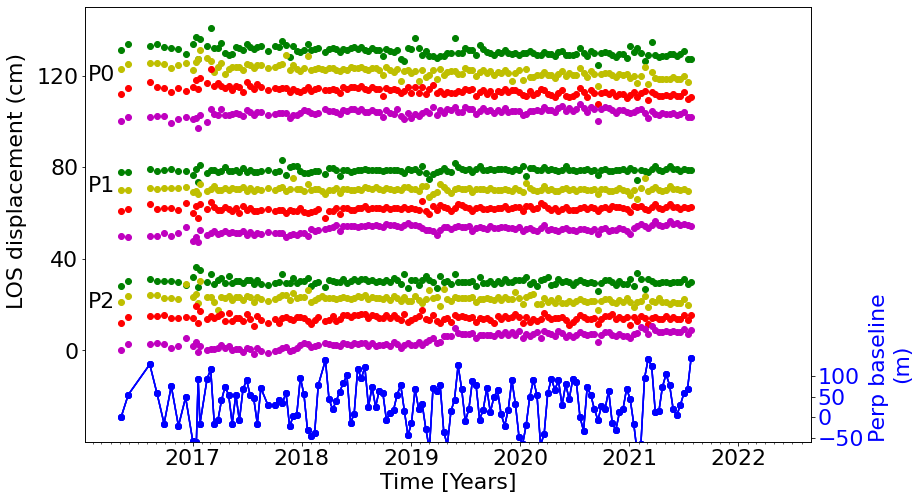

In [82]:
plt.rcParams["font.size"] = "22"
plt.rcParams["legend.framealpha"] = '0.5'
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()

colors = ['lightcoral', 'darkviolet','aquamarine','springgreen','forestgreen','darkgreen']

shifts = [50,35,20,0]
lsh = np.array([[31,23,12,0],
                [28,20,11,0],
               [28,21,12,0]])


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(13, 8))

msize = 15
fsize=8

shift = [100, 50, 0]

labels = ['Single reference','Delaunay','Annual ministacks', 'Sequential']

ax1 = axs
ax2 = ax1.twinx()


for t in range(len(points_lalo1)):
    ax1.plot(dates_sr, ts_sr[t, :] - ts_sr[t, 0] + lsh[t,0]+ shift[t], 'go',markersize=6, linewidth=1)
    
    ax1.plot(dates_ms, ts_ms[t, :] - ts_ms[t, 0] + lsh[t,1]+ shift[t], 'yo',markersize=6,  linewidth=1)
    ax1.plot(dates_de, ts_de[t, :] - ts_de[t, 0] + lsh[t,2]+ shift[t], 'ro',markersize=6,  linewidth=1)
    
    ax1.plot(dates_se3, ts_se3[t, :] - ts_se3[t, 0] + lsh[t,3]+ shift[t], 'mo',markersize=6,  linewidth=1)
    
    
    ax2.plot(dates_sr, bslines, 'bo-', markersize=6)
    
    '''
    ax1.text(dates_ms[-1] + datetime.timedelta(days=20), 
             ts_ms[t, -1] - ts_ms[t, 0] + lsh[t,0]+ shift[t], 
             labels[0], color='g')
    
    ax1.text(dates_sr[-1] + datetime.timedelta(days=20), 
             ts_sr[t, -1] - ts_sr[t, 0] + lsh[t,1]+ shift[t], 
             labels[1], color='y')
    
    ax1.text(dates_de[-1] + datetime.timedelta(days=20), 
             ts_de[t, -1] - ts_de[t, 0] + lsh[t,2]+ shift[t], 
             labels[2], color='r')
    
    ax1.text(dates_se3[-1] + datetime.timedelta(days=20), 
             ts_se3[t, -1] - ts_se3[t, 0] + lsh[t,3]+ shift[t], 
             labels[3], color='m')
    '''

    
    ax1.xaxis.set_major_locator(years)
    ax1.xaxis.set_major_formatter(years_fmt)
    ax1.xaxis.set_minor_locator(months)
    ax1.autoscale_view()
    
ax1.text(dates_se3[0]-datetime.timedelta(days=110) , (ts_sr[0, -1] - (ts_de[0, -1]))+ shifts[2]+shift[0], 'P0')
ax1.text(dates_se3[0]-datetime.timedelta(days=110) , (ts_sr[1, -1] - (ts_de[1, -1]))+ shifts[2]+shift[1], 'P1')
ax1.text(dates_se3[0]-datetime.timedelta(days=110) , (ts_sr[2, -1] - (ts_de[2, -1]))+ shifts[2]+shift[2], 'P2')

ax1.set_xlim(dates_se3[0]-datetime.timedelta(days=120), dates_se3[-1]+datetime.timedelta(days=400))
#ax1.legend(('Single reference','Mini stacks', 'Delaunay','Fully connected sequential','Partially connected sequential'), 
#           loc='lower left', bbox_to_anchor=(0,-1))

ax2.set_ylim(-60, 1000)
ax1.set_ylim(-40, 150)
ax2.set_ylabel('Perp baseline \n(m)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_ylabel('LOS displacement (cm)')

ax1.set_xlabel('Time [Years]')

#ax1.legend(labels, bbox_to_anchor=(0.85,0.92),shadow=True, fontsize=20)
#ax1.legend(labels, bbox_to_anchor=(1.41,0.92), loc=1, framealpha=1)

ax2.set_yticks((-50, 0, 50, 100))
ax1.set_yticks((0, 40, 80, 120))
ax1.yaxis.set_label_coords(-0.08, 0.6)
ax2.yaxis.set_label_coords(1.08, 0.18)
ax1.set_xticks((datetime.datetime(2017, 1, 1, 0, 0), 
                datetime.datetime(2018, 1, 1, 0, 0),
                datetime.datetime(2019, 1, 1, 0, 0),
                datetime.datetime(2020, 1, 1, 0, 0),
                datetime.datetime(2021, 1, 1, 0, 0),
                datetime.datetime(2022, 1, 1, 0, 0)))
plt.savefig(out_dir + '/LAssen_timeseries_unwrap_compare.png', bbox_inches='tight', transparent=True, dpi=300)

plt.show()


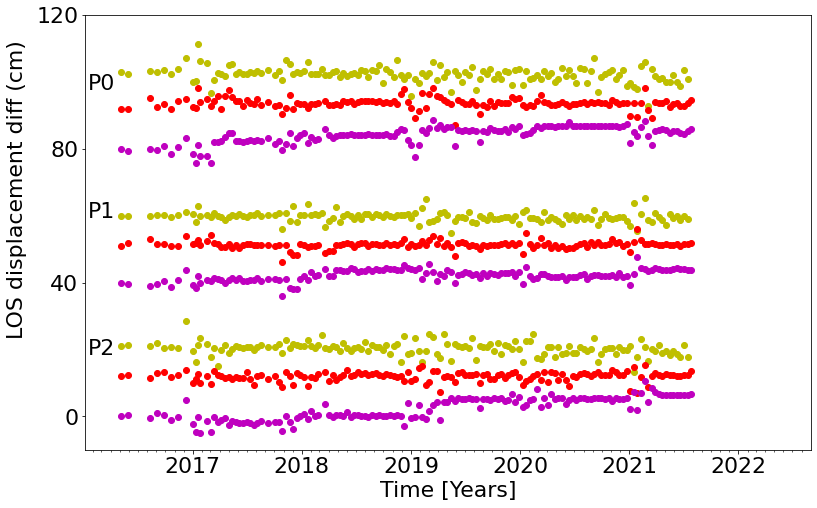

In [90]:
plt.rcParams["font.size"] = "22"
plt.rcParams["legend.framealpha"] = '0.5'
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()

colors = ['lightcoral', 'darkviolet','aquamarine','springgreen','forestgreen','darkgreen']

shifts = [50,35,20,0]
lsh = np.array([[31,23,12,0],
                [28,20,11,0],
               [28,21,12,0]])


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(13, 8))

msize = 15
fsize=8

shift = [80, 40, 0]

labels = ['Single reference','Delaunay','Annual ministacks', 'Sequential']

ax1 = axs
#ax2 = ax1.twinx()


for t in range(len(points_lalo1)):
    sr_ts = ts_sr[t, :] - ts_sr[t, 0]
    #ax1.plot(dates_sr, ts_sr[t, :] - ts_sr[t, 0] + lsh[t,0]+ shift[t], 'go',markersize=6, linewidth=1)
    
    ax1.plot(dates_ms, ts_ms[t, :] - ts_ms[t, 0] -sr_ts  + lsh[t,1]+ shift[t], 'yo',markersize=6,  linewidth=1)
    ax1.plot(dates_de, ts_de[t, :] - ts_de[t, 0]-sr_ts + lsh[t,2]+ shift[t], 'ro',markersize=6,  linewidth=1)
    
    ax1.plot(dates_se3, ts_se3[t, :] - ts_se3[t, 0]-sr_ts + lsh[t,3]+ shift[t], 'mo',markersize=6,  linewidth=1)
    
    
    #ax2.plot(dates_sr, bslines, 'bo-', markersize=6)
    

    
    ax1.xaxis.set_major_locator(years)
    ax1.xaxis.set_major_formatter(years_fmt)
    ax1.xaxis.set_minor_locator(months)
    ax1.autoscale_view()
    
ax1.text(dates_se3[0]-datetime.timedelta(days=110) , (ts_sr[0, -1] - (ts_de[0, -1]))+ shifts[2]+shift[0], 'P0')
ax1.text(dates_se3[0]-datetime.timedelta(days=110) , (ts_sr[1, -1] - (ts_de[1, -1]))+ shifts[2]+shift[1], 'P1')
ax1.text(dates_se3[0]-datetime.timedelta(days=110) , (ts_sr[2, -1] - (ts_de[2, -1]))+ shifts[2]+shift[2], 'P2')

ax1.set_xlim(dates_se3[0]-datetime.timedelta(days=120), dates_se3[-1]+datetime.timedelta(days=400))
#ax1.legend(('Single reference','Mini stacks', 'Delaunay','Fully connected sequential','Partially connected sequential'), 
#           loc='lower left', bbox_to_anchor=(0,-1))

#ax2.set_ylim(-60, 1000)
ax1.set_ylim(-10, 100)
#ax2.set_ylabel('Perp baseline \n(m)', color='blue')
#ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_ylabel('LOS displacement diff (cm)')

ax1.set_xlabel('Time [Years]')

#ax1.legend(labels, bbox_to_anchor=(0.85,0.92),shadow=True, fontsize=20)
#ax1.legend(labels, bbox_to_anchor=(1.41,0.92), loc=1, framealpha=1)

#ax2.set_yticks((-50, 0, 50, 100))
ax1.set_yticks((0, 40, 80, 120))
ax1.yaxis.set_label_coords(-0.08, 0.6)
ax2.yaxis.set_label_coords(1.08, 0.18)
ax1.set_xticks((datetime.datetime(2017, 1, 1, 0, 0), 
                datetime.datetime(2018, 1, 1, 0, 0),
                datetime.datetime(2019, 1, 1, 0, 0),
                datetime.datetime(2020, 1, 1, 0, 0),
                datetime.datetime(2021, 1, 1, 0, 0),
                datetime.datetime(2022, 1, 1, 0, 0)))
plt.savefig(out_dir + '/LAssen_timeseries_unwrap_compare_diff.png', bbox_inches='tight', transparent=True, dpi=300)

plt.show()


In [128]:
tsStack_minopy = prj_dir + '/old/timeseries_SET_ERA5_demErr.h5'
gStack_minopy = prj_dir + '/old/inputs/geometryRadar.h5'

attr_minopy = readfile.read_attribute(tsStack_minopy)

coord_minopy = ut.coordinate(attr_minopy, gStack_minopy)

# P0
yg_minopy1, xg_minopy1 = coord_minopy.geo2radar(points_lalo1[0][0], points_lalo1[0][1])[0:2]
vec_refined_1, temp_quality_1, coh_mat_1, shp_1, amp_1, data_1, col0_1, row0_1 = process_pixel((yg_minopy1, xg_minopy1), prj_dir + '/old/slcStack.h5')

# P1
yg_minopy2, xg_minopy2 = coord_minopy.geo2radar(points_lalo1[1][0], points_lalo1[1][1])[0:2]
vec_refined_2, temp_quality_2, coh_mat_2, shp_2, amp_2, data_2, col0_2, row0_2 = process_pixel((yg_minopy2, xg_minopy2), prj_dir + '/old/slcStack.h5')

# P2
yg_minopy3, xg_minopy3 = coord_minopy.geo2radar(points_lalo1[2][0], points_lalo1[2][1])[0:2]
vec_refined_3, temp_quality_3, coh_mat_3, shp_3, amp_3, data_3, col0_3, row0_3 = process_pixel((yg_minopy3, xg_minopy3), prj_dir + '/old/slcStack.h5')

(100, 100)
0.5445485189928829
(100, 100)
0.466181023547574
(100, 100)
0.3759845246938889


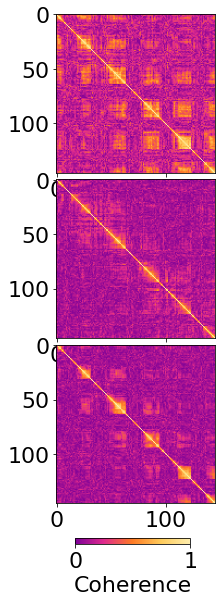

In [136]:
plt.rcParams["font.size"] = "22"
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 8))

ax = axs[0]
im=ax.imshow(np.abs(np.array(coh_mat_1)), vmin=0, vmax=1, cmap=cmapc)
ax = axs[1]
ax.imshow(np.abs(np.array(coh_mat_2)), vmin=0, vmax=1, cmap=cmapc)
ax = axs[2]
ax.imshow(np.abs(np.array(coh_mat_3)), vmin=0, vmax=1, cmap=cmapc)

cbar_ax2 = fig.add_axes([0.42, 0.03, 0.2, 0.01])
#cbar_ax2 = fig.add_axes([0.5, 0.01, 0.005, 0.15, ])
fig.colorbar(im, cax=cbar_ax2, ticks=[0, 1], label='Coherence', orientation='horizontal')
fig.subplots_adjust(wspace=0.1, hspace=0.04, left=0.1, right=0.95, top=0.95, bottom=0.1)      

plt.savefig(out_dir + '/Lassen_timeseries_unwrap_compare_coh_matrix.png', bbox_inches='tight', transparent=True, dpi=300)
